## Pre-Processing

### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import pickle

### Load the Data

In [5]:
df = pd.read_csv('sales_cleaned.csv', index_col='Order Date', parse_dates=True).sort_index()

In [6]:
df.shape

(9800, 12)

In [7]:
df.head()

,Segment,Region,Category,Year,Month,Day,Weekday,Week,Quarter,Is Weekend,Sales,Log_Sales
Order Date,,,,,,,,,,,,
2015-01-03,Consumer,Central,Office Supplies,2015,1,3,5,1,1,1,16.448,2.859225
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,3.540,1.512927
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,272.736,5.612164
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,11.784,2.548194
2015-01-05,Consumer,East,Office Supplies,2015,1,5,0,2,1,0,19.536,3.022179


### Tests for Autocorrelation and Stationarity (to be moved to EDA)

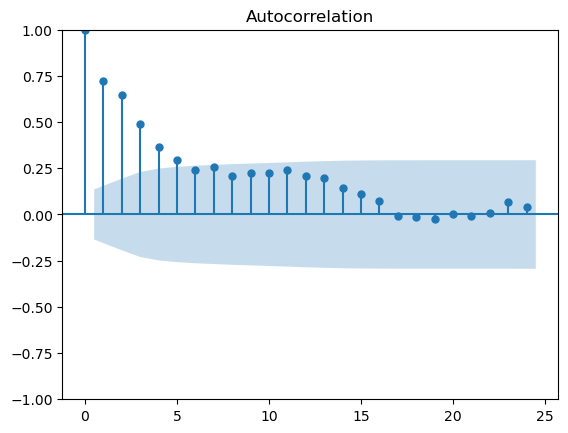

In [9]:
df_resampled = df['Log_Sales'].resample('W').sum()
plot_acf(df_resampled.dropna())
plt.show()

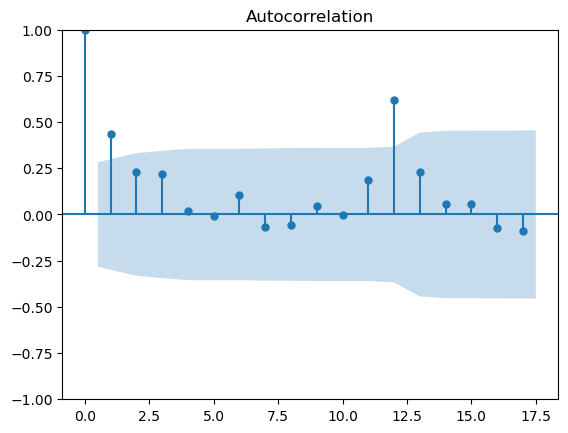

In [10]:
df_resampled = df['Log_Sales'].resample('ME').sum()
plot_acf(df_resampled.dropna())
plt.show()

We can see that lags 1-5 show significant autocorrelation for weekly resampled data, whereas lags 1 and 12 are significant for monthly resampling.  
We will focus on monthly trends and seasonality, but it is good to know we can explore weekly trends should there be a desire for a finer granularity.

In [12]:
# Perform the ADF test
result = adfuller(df_resampled)

# Output the test statistic and p-value
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.6492853082013794
p-value: 0.0048857680547952495


With a p-value of 0.005, the Augmented Dickey-Fuller test results indicate our monthly resample data is stationary.

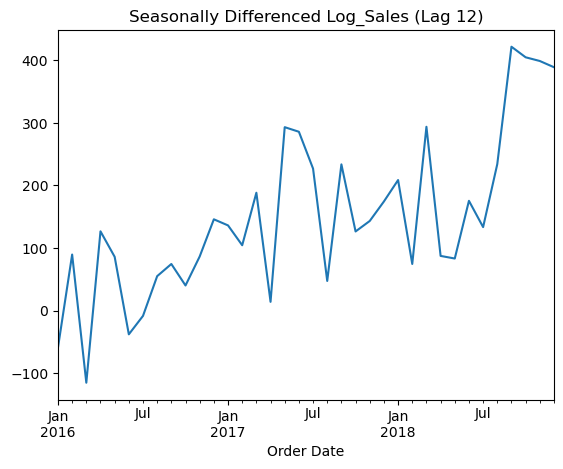

ADF Statistic (Seasonal Differenced): -1.2522490072728625
p-value: 0.6507257270443164


In [14]:
# Seasonal differencing
df_seasonal_diff = df_resampled - df_resampled.shift(12)
df_seasonal_diff = df_seasonal_diff.dropna()

df_seasonal_diff.plot(title="Seasonally Differenced Log_Sales (Lag 12)")
plt.show()

result = adfuller(df_seasonal_diff)

print("ADF Statistic (Seasonal Differenced):", result[0])
print("p-value:", result[1])

The seasonally differenced data is non-stationary. Since the original Log_Sales variable is stationary, we will not incorporate differencing and, instead, allow the model to capture the trend/seasonality directly via the AR/MA components.

### Resampling & One-Hot Encoding

Creating a custom function to handle the delicate process of resampling the data can be helpful for preparing data for different models. We must separate and aggregate column types individually to avoid illogical sums or concatenations of strings when resampling. We will also create dummy variables for categorical features, ensure all encoded columns exist (important for neural nets), and convert all boolean values to integers. Finally, we merge the results back together.

In [18]:
def resample(df, freq='ME', drop=True):
    df = df.copy()

    # Columns
    metric_cols = ['Sales']
    log_col = 'Log_Sales'
    cat_cols = ['Segment', 'Region', 'Category']
    time_cols = ['Year', 'Month', 'Day', 'Weekday', 'Week', 'Quarter', 'Is Weekend']

    # Combine all relevant columns for aggregation
    all_cols = metric_cols + time_cols + cat_cols

    # Get expected dummy columns before resampling
    df_dummies_full = pd.get_dummies(df[cat_cols], drop_first=drop)
    expected_dummies = df_dummies_full.columns.tolist()

    # Custom mode function (handles empty mode case)
    def mode_agg(x):
        mode_val = x.mode()
        return mode_val[0] if not mode_val.empty else np.nan

    # Aggregation dict
    agg_dict = {
        **{col: 'sum' for col in metric_cols},
        **{col: mode_agg for col in time_cols + cat_cols}
    }

    # Resample + aggregate
    df_resampled = df[all_cols].resample(freq).agg(agg_dict)

    # One-hot encode categorical columns
    df_encoded = pd.get_dummies(df_resampled, columns=cat_cols)

    # Ensure all expected dummy columns exist
    for col in expected_dummies:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    
    # Recalculate Log_Sales after resampling
    df_encoded[log_col] = np.log(df_encoded['Sales'] + 1)

    # Convert booleans to integers
    bool_cols = df_encoded.select_dtypes(include='bool').columns
    df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

    return df_encoded

### Model-Specific Prep

#### SARIMA

In [21]:
# Only Log_Sales for SARIMA
df_sarima = resample(df)['Log_Sales']

#### SARIMAX

In [23]:
df_sarimax = resample(df)

# Add cyclical encoding for time variables with SARIMAX
df_sarimax['Month_sin'] = np.sin(2 * np.pi * df_sarimax['Month'] / 12)
df_sarimax['Month_cos'] = np.cos(2 * np.pi * df_sarimax['Month'] / 12)

df_sarimax['Weekday_sin'] = np.sin(2 * np.pi * df_sarimax['Weekday'] / 7)
df_sarimax['Weekday_cos'] = np.cos(2 * np.pi * df_sarimax['Weekday'] / 7)

# Create lags and rolling stats
df_sarimax['Lag_1'] = df_sarimax['Log_Sales'].shift(1)
df_sarimax['Lag_12'] = df_sarimax['Log_Sales'].shift(12)
df_sarimax['Rolling_Mean_3'] = df_sarimax['Log_Sales'].rolling(window=3).mean()
df_sarimax['Rolling_Std_3'] = df_sarimax['Log_Sales'].rolling(window=3).std()
df_sarimax['Rolling_Mean_12'] = df_sarimax['Log_Sales'].rolling(window=12).mean()
df_sarimax['Rolling_Std_12'] = df_sarimax['Log_Sales'].rolling(window=12).std()
df_sarimax.dropna(inplace=True)

In [24]:
# Drop features already captured or unnecessary
df_sarimax.drop(columns=['Month', 'Weekday', 'Day', 'Week', 'Quarter'], inplace=True)

In [25]:
df_sarimax

,Sales,Year,Is Weekend,Segment_Consumer,Segment_Corporate,Region_Central,Region_East,Region_South,Region_West,Category_Office Supplies,...,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Lag_1,Lag_12,Rolling_Mean_3,Rolling_Std_3,Rolling_Mean_12,Rolling_Std_12
Order Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,18066.9576,2016,1,1,0,0,1,0,0,1,...,5.000000e-01,8.660254e-01,-0.974928,-0.222521,11.129731,9.561469,10.731640,0.807947,10.381938,0.788527
2016-02-29,11951.4110,2016,0,1,0,0,1,0,0,1,...,8.660254e-01,5.000000e-01,-0.974928,-0.222521,9.801895,8.416465,10.106772,0.909681,10.462957,0.594231
2016-03-31,32339.3184,2016,0,1,0,0,0,0,1,1,...,1.000000e+00,6.123234e-17,0.781831,0.623490,9.388688,10.918841,9.858218,0.500075,10.418393,0.576728
2016-04-30,34154.4685,2016,0,1,0,1,0,0,0,1,...,8.660254e-01,-5.000000e-01,0.000000,1.000000,10.384070,10.236663,10.070479,0.591079,10.435227,0.573883
2016-05-31,29959.5305,2016,0,1,0,0,1,0,0,1,...,5.000000e-01,-8.660254e-01,0.781831,0.623490,10.438678,10.070920,10.376795,0.065823,10.454953,0.564209
2016-06-30,23599.3740,2016,0,1,0,0,0,1,0,1,...,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,10.307636,10.443598,10.271777,0.187421,10.423738,0.575150
2016-07-31,28608.2590,2016,0,1,0,0,1,0,0,1,...,-5.000000e-01,-8.660254e-01,-0.974928,-0.222521,10.069018,10.427699,10.212713,0.126565,10.409887,0.577044
2016-08-31,36818.3422,2016,0,1,0,0,0,0,1,1,...,-8.660254e-01,-5.000000e-01,0.781831,0.623490,10.261486,10.207973,10.281427,0.223050,10.435371,0.574061
2016-09-30,63133.6060,2016,0,1,0,0,1,0,0,1,...,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,10.513779,11.309885,10.609430,0.404345,10.413966,0.542405


#### LSTM

While regression or cluster models require dropping the first dummy variable, we must specify to keep all dummy variables by setting the drop parameter of our custom function to False for LSTM.

In [28]:
df_lstm = resample(df, drop=False)

# Add cyclical encodings
df_lstm['Month_sin'] = np.sin(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Month_cos'] = np.cos(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Weekday_sin'] = np.sin(2 * np.pi * df_lstm['Weekday'] / 7)
df_lstm['Weekday_cos'] = np.cos(2 * np.pi * df_lstm['Weekday'] / 7)

# Drop raw data
df_lstm.drop(columns=['Month', 'Day', 'Weekday', 'Week', 'Quarter'], inplace=True)

Different time series models have different input needs. SARIMA/SARIMAX do not need scaling, but it is important for LSTM. 

In [30]:
scaler = MinMaxScaler()
features = df_lstm.drop(columns=['Log_Sales']).columns
df_lstm[features] = scaler.fit_transform(df_lstm[features])

Next, we need to create lag features to help LSTM understand time.

In [32]:
n_steps = 12
X = []
y = []

for i in range(n_steps, len(df_lstm)):
    X.append(df_lstm.iloc[i-n_steps:i].values) # sequences of shape (n_steps, n_features)
    y.append(df_lstm.iloc[i]['Log_Sales'])     # target is next timestep

X = np.array(X)
y = np.array(y)

### Training/Test Split

SARIMA does not use features other than the target feature and time. SARIMAX utilizes lag features and rolling stats, which reduces the total number of rows. While including those features would be beneficial to LSTM, I have opted to not include them due to limited data availability. These nuances create a new problem - each df contains a different number of observations.

Ultimately, we want to see which model performs the best, but the usual method of training on 80% of the dataset will not work here. Instead, we can explicitly define a test index to guarantee all models are trained on the same months.

In [35]:
common_index = df_sarima.index.intersection(df_sarimax.index).intersection(df_lstm.index)
test_index = common_index[-12:]
dfs = {
    'sarima': df_sarima.loc[test_index],
    'sarimax': df_sarimax.loc[test_index],
    'lstm': df_lstm.loc[test_index]
}

train_dfs = {
    'sarima': df_sarima.drop(index=test_index),
    'sarimax': df_sarimax.drop(index=test_index),
    'lstm': df_lstm.drop(index=test_index)
}

In [36]:
with open('pre-processed_data.pkl', 'wb') as f:
    pickle.dump({
        'df_sarima': df_sarima,
        'df_sarimax': df_sarimax,
        'df_lstm': df_lstm,
        'sarima_train': train_dfs['sarima'],
        'sarima_test': dfs['sarima'],
        'sarimax_train': train_dfs['sarimax'],
        'sarimax_test': dfs['sarimax'],
        'lstm_train': train_dfs['lstm'],
        'lstm_test': dfs['lstm']
    }, f)